# Compare tidal levels
This scrips compares observed and modeled water levels.

- The observed water levels start at line 15 of a tab-separated file, and have two fields: "Date/Time" and "WL [m]". 

- The modeled water levels start at line 1 of a csv file, and have two fields: "date and time" and "water level (when dry: bed level) (m)". 

Dates are parsed automatically.

In [194]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

First, we give as input the filenames where data is stored and the coordinates of the station

In [195]:
# Site name
sitename='Tambakulu'

# File names where data is stored
filename_obs='field_data\Tambakulu_water_level_logger.tab'
filename_model='model\Tambakulu.csv'

Then, the input data is imported into pandas dataframes, with datetime as index. The model file is clipped to the dates of the observation file.

In [196]:
#Read observation file and set datetime as index
field_WL = pd.read_csv(filename_obs, sep='\t',  lineterminator='\n', skiprows=14)
field_WL['Date/Time'] =  pd.to_datetime(field_WL['Date/Time'], infer_datetime_format=True)
start_time=min(field_WL['Date/Time'])
end_time=max(field_WL['Date/Time'])
field_WL.set_index(['Date/Time'],inplace=True)
#Read model file and 
model_WL = pd.read_csv(filename_model)
model_WL['date and time'] =  pd.to_datetime(model_WL['date and time'], infer_datetime_format=True)
mask = (model_WL['date and time'] > start_time) & (model_WL['date and time'] < end_time)
model_WL = model_WL.loc[mask]
model_WL.set_index(['date and time'],inplace=True)

To compare water levels, we subtract the average water level in the measurement period for both observed and modeled water levels

In [197]:
#Calculate average water level
model_WL['water level (when dry: bed level) (m)']=model_WL['water level (when dry: bed level) (m)']-np.mean(model_WL['water level (when dry: bed level) (m)'])
field_WL['WL [m]']=field_WL['WL [m]']-np.mean(field_WL['WL [m]'])

We then align the two datasets to the one with lower temporal resolution (the modeled water levels) and calculate the difference between observed and modeled water levels.

In [198]:
diff = pd.concat([model_WL, field_WL], axis=1)
diff = diff.dropna(subset=['water level (when dry: bed level) (m)'])
diff['diff']=diff['WL [m]']-diff['water level (when dry: bed level) (m)']
diff.drop(columns=['water level (when dry: bed level) (m)','WL [m]'], inplace=True)

Finally, the data and a site map are plotted.

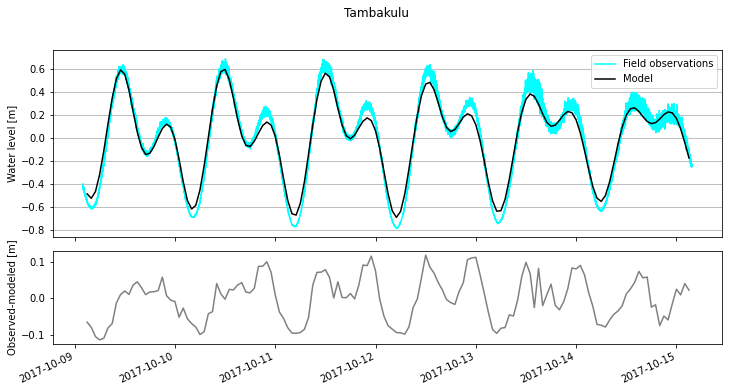

In [199]:
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, hspace=0.1,height_ratios=[4,2]) 

axs = gs.subplots(sharex=True)
fig.suptitle(sitename)
#Plotting water level data
axs[0].plot(field_WL.index,field_WL['WL [m]'],color='cyan', label='Field observations')
axs[0].plot(model_WL.index,model_WL['water level (when dry: bed level) (m)'],color='black', label='Model')
#plotting difference
axs[1].plot(diff.index,diff['diff'],color='gray', label='Observed-Modeled')
for ax in axs:
    ax.label_outer()
fig.autofmt_xdate(rotation=25)
axs[0].set(ylabel='Water level [m]')
axs[1].set(ylabel='Observed-modeled [m]')
axs[0].legend()
axs[0].grid(which='major', axis='y')

fname=sitename+'.png'
plt.savefig(fname, dpi=300, format='png')
